In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas numpy matplotlib scikit-learn pmdarima ydata-profiling tensorflow==2.* tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [19]:
import os, random, json, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

DATA_DIR = Path("/content/drive/MyDrive/5A_GIIADS/Applied_deep_learning/M5_forcasting")
SALES_FILE = DATA_DIR/"sales_train_validation.csv"
CAL_FILE   = DATA_DIR/"calendar.csv"
PRICE_FILE = DATA_DIR/"sell_prices.csv"

N_ARTICLES = 10
N_JOURS = 60
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [20]:
sales = pd.read_csv(SALES_FILE)
cal   = pd.read_csv(CAL_FILE)
prices= pd.read_csv(PRICE_FILE)

print("sales:", sales.shape, "calendar:", cal.shape, "prices:", prices.shape)

sales: (30490, 1919) calendar: (1969, 14) prices: (6841121, 4)


In [21]:
# ---------- RÉDUCTION ----------
day_cols_all = [c for c in sales.columns if c.startswith("d_")]
day_cols_60  = [f"d_{i}" for i in range(1, N_JOURS+1)]
assert set(day_cols_60).issubset(day_cols_all), "Pas assez de jours dans le fichier."

items = random.sample(sales["item_id"].unique().tolist(), N_ARTICLES)
meta_cols = ['id','item_id','dept_id','cat_id','store_id','state_id']
sales_red = sales[sales["item_id"].isin(items)][meta_cols+day_cols_60].reset_index(drop=True)

cal_red = cal[cal["d"].isin(day_cols_60)].copy()
weeks_60 = cal_red["wm_yr_wk"].unique()
prices_red = prices[prices["wm_yr_wk"].isin(weeks_60)].copy()

In [22]:
# ---------- DISPLAY APERÇU ----------
print("sales_red:", sales_red.shape); display(sales_red.head())
print("calendar (60 jours):", cal_red.shape); display(cal_red.head())
print("sell_prices (semaines correspondantes):", prices_red.shape); display(prices_red.head())

sales_red: (100, 66)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60
0,HOBBIES_1_107_CA_1_validation,HOBBIES_1_107,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_2_004_CA_1_validation,HOBBIES_2_004,HOBBIES_2,HOBBIES,CA_1,CA,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,HOBBIES_2_041_CA_1_validation,HOBBIES_2_041,HOBBIES_2,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOUSEHOLD_1_007_CA_1_validation,HOUSEHOLD_1_007,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOUSEHOLD_1_357_CA_1_validation,HOUSEHOLD_1_357,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,5,3,4,2,...,5,1,1,1,3,2,3,4,4,5


calendar (60 jours): (60, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


sell_prices (semaines correspondantes): (115950, 4)


,store_id,item_id,wm_yr_wk,sell_price
541,CA_1,HOBBIES_1_004,11106,4.34
542,CA_1,HOBBIES_1_004,11107,4.34
543,CA_1,HOBBIES_1_004,11108,4.34
544,CA_1,HOBBIES_1_004,11109,4.34
1512,CA_1,HOBBIES_1_008,11101,0.46


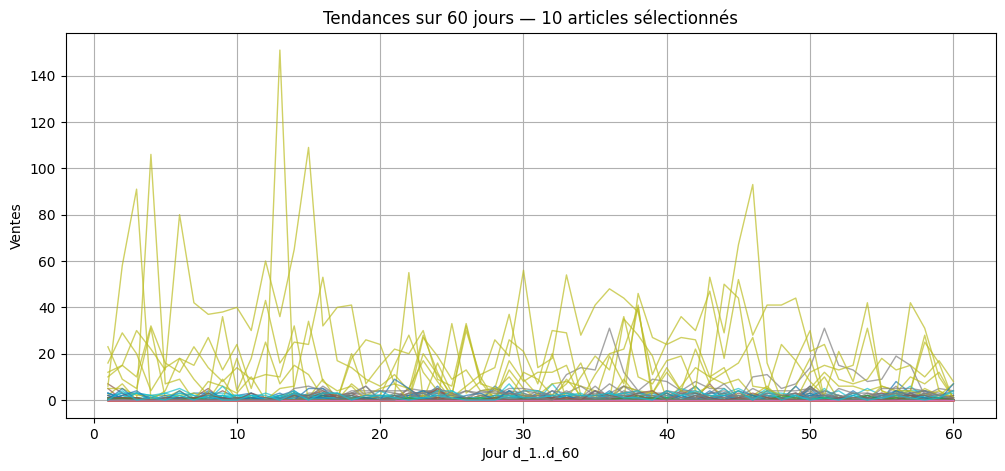

In [16]:
# ---------- TENDANCES (plot) ----------
plt.figure(figsize=(12,5))
for _, r in sales_red.iterrows():
    plt.plot(range(1, N_JOURS+1), r[day_cols_60].astype(float).values, alpha=0.7, lw=1)
plt.title(f"Tendances sur {N_JOURS} jours — {N_ARTICLES} articles sélectionnés")
plt.xlabel("Jour d_1..d_60"); plt.ylabel("Ventes"); plt.grid(True); plt.show()

On observe que la majorité des séries restent proches de zéro, avec des pics isolés pour quelques produits, atteignant parfois plus de 100 unités vendues sur certains jours.
Les ventes présentent donc une grande variabilité entre produits, mais la plupart des séries restent faiblement actives.
Globalement, il n’y a pas de tendance claire ni de saisonnalité apparente sur ces 60 premiers jours : le comportement est plutôt irrégulier.

In [25]:
# ---------- PROFILING (rapide) ----------
from ydata_profiling import ProfileReport
long_df = sales_red.melt(id_vars=meta_cols, value_vars=day_cols_60, var_name="d", value_name="sales")
long_df = long_df.merge(cal_red[["d","date","wm_yr_wk","wday","weekday","month","year"]], on="d", how="left")
sample = long_df.sample(min(4000, len(long_df)), random_state=RANDOM_SEED)
ProfileReport(sample, title="M5 Reduced Profiling", minimal=True, explorative=True).to_file("m5_profile.html")
print("Profiling écrit -> m5_profile.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 59.11it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profiling écrit -> m5_profile.html


Le rapport de profiling a été généré avec succès.
Le processus montre que toutes les étapes (lecture, résumé du dataset, génération de la structure et rendu HTML) se sont exécutées sans erreur.
Le fichier m5_profile.html a bien été exporté — il contient l’analyse complète du dataset réduit (distributions, valeurs manquantes, types de variables, corrélations, etc.).
Le temps d’exécution (~6 s pour la génération du rapport) confirme que le sous-échantillon choisi (4000 lignes) est bien adapté pour un profiling rapide et fluide.

In [10]:
from ydata_profiling import ProfileReport

sales_long = sales_red.melt(id_vars=meta_cols, value_vars=day_cols_60, var_name="d", value_name="sales")
sales_long = sales_long.merge(cal_red[["d","date","wm_yr_wk","wday","weekday","month","year"]], on="d", how="left")
sample_long = sales_long.sample(min(5000, len(sales_long)), random_state=RANDOM_SEED).reset_index(drop=True)

profile = ProfileReport(sample_long, title="M5 – Reduced Profiling", explorative=True, minimal=True)
profile.to_file("m5_reduced_profile.html")
print("Profiling généré: m5_reduced_profile.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 49.36it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profiling généré: m5_reduced_profile.html


In [26]:
# === 7) PRÉPARATION APPRENTISSAGE SUPERVISÉ (fenêtres glissantes) ===
W = 20
VAL_HORIZON = 7

def build_sequences(series, w=W):
    """
    series: array-like 1D (longueur N)
    retourne X: (N-w, w)  , y: (N-w,)
    """
    series = np.asarray(series, dtype=float)
    X, y = [], []
    for t in range(w, len(series)):
        X.append(series[t-w:t])
        y.append(series[t])
    return np.array(X), np.array(y)

In [27]:
# Construire un dataset global en concaténant toutes les séries sélectionnées
all_X_train, all_y_train, all_X_val, all_y_val = [], [], [], []

for _, row in sales_red.iterrows():
    y = row[day_cols_60].values.astype(float)
    X, y_seq = build_sequences(y, w=W)
    if len(y_seq) <= VAL_HORIZON:
        continue
    # split train / val sur la fin
    X_tr, y_tr = X[:-VAL_HORIZON], y_seq[:-VAL_HORIZON]
    X_v,  y_v  = X[-VAL_HORIZON:], y_seq[-VAL_HORIZON:]
    all_X_train.append(X_tr); all_y_train.append(y_tr)
    all_X_val.append(X_v);   all_y_val.append(y_v)

X_train = np.vstack(all_X_train)
y_train = np.concatenate(all_y_train)
X_val   = np.vstack(all_X_val)
y_val   = np.concatenate(all_y_val)

print("X_train:", X_train.shape, "X_val:", X_val.shape)

X_train: (3300, 20) X_val: (700, 20)


In [28]:
# === 8) MODÈLES NEURAUX: MLP / SimpleRNN / LSTM / GRU ===
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import mean_squared_error
import math

def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

# Mise en forme des données
# - MLP attend (None, W)
# - RNN/LSTM/GRU attendent (None, W, 1)
X_train_rnn = X_train[..., None]
X_val_rnn   = X_val[..., None]

# --- Définition des architectures ---
def build_mlp(w):
    m = models.Sequential([
        layers.Input(shape=(w,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

def build_rnn(w):
    m = models.Sequential([
        layers.Input(shape=(w,1)),
        layers.SimpleRNN(64, return_sequences=False),
        layers.Dense(1)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

def build_lstm(w):
    m = models.Sequential([
        layers.Input(shape=(w,1)),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(1)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

def build_gru(w):
    m = models.Sequential([
        layers.Input(shape=(w,1)),
        layers.GRU(64, return_sequences=False),
        layers.Dense(1)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

ES = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

def train_and_eval(model, Xtr, ytr, Xv, yv, epochs=50, batch_size=64, rnn=False):
    if rnn:
        hist = model.fit(Xtr, ytr, validation_data=(Xv, yv),
                         epochs=epochs, batch_size=batch_size,
                         verbose=0, callbacks=[ES])
    else:
        hist = model.fit(Xtr, ytr, validation_data=(Xv, yv),
                         epochs=epochs, batch_size=batch_size,
                         verbose=0, callbacks=[ES])
    yhat = model.predict(Xv, verbose=0).reshape(-1)
    return rmse(yv, yhat), hist

In [29]:
# --- Entraînement et évaluation ---
results = {}

# MLP
mlp = build_mlp(W)
rmse_mlp, _ = train_and_eval(mlp, X_train, y_train, X_val, y_val,
                             epochs=100, batch_size=64, rnn=False)
results["MLP"] = rmse_mlp
print("MLP RMSE:", rmse_mlp)

# SimpleRNN
rnn = build_rnn(W)
rmse_rnn, _ = train_and_eval(rnn, X_train_rnn, y_train, X_val_rnn, y_val,
                             epochs=100, batch_size=64, rnn=True)
results["RNN"] = rmse_rnn
print("RNN RMSE:", rmse_rnn)

# LSTM
lstm = build_lstm(W)
rmse_lstm, _ = train_and_eval(lstm, X_train_rnn, y_train, X_val_rnn, y_val,
                              epochs=100, batch_size=64, rnn=True)
results["LSTM"] = rmse_lstm
print("LSTM RMSE:", rmse_lstm)

# GRU
gru = build_gru(W)
rmse_gru, _ = train_and_eval(gru, X_train_rnn, y_train, X_val_rnn, y_val,
                             epochs=100, batch_size=64, rnn=True)
results["GRU"] = rmse_gru
print("GRU RMSE:", rmse_gru)

MLP RMSE: 0.8023044101926059
RNN RMSE: 0.8264184736462129
LSTM RMSE: 0.819972614172631
GRU RMSE: 0.8168358015755829



=== Résultats (RMSE plus petit = meilleur) ===
   MLP : 0.8023
   RNN : 0.8264
  LSTM : 0.8200
   GRU : 0.8168

>>> Meilleur modèle: MLP (RMSE=0.8023)


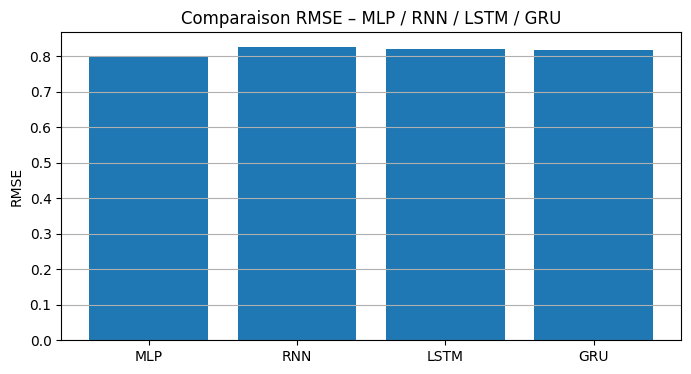

✅ Fichiers écrits:
- sales_reduced_10items_60days.csv, calendar_60days_only.csv, calendar_weeks_for_60days.csv, sell_prices_weeks_for_60days.csv, model_selection_results.json


In [30]:
# --- Résumé des performances ---
print("\n=== Résultats (RMSE plus petit = meilleur) ===")
for k, v in results.items():
    print(f"{k:>6} : {v:.4f}")

best_model = min(results, key=results.get)
print(f"\n>>> Meilleur modèle: {best_model} (RMSE={results[best_model]:.4f})")

# --- Visualisation des erreurs ---
plt.figure(figsize=(8,4))
plt.bar(list(results.keys()), list(results.values()))
plt.title("Comparaison RMSE – MLP / RNN / LSTM / GRU")
plt.ylabel("RMSE")
plt.grid(axis="y")
plt.show()

# --- Export des jeux réduits et résultats ---
sales_red.to_csv("sales_reduced_10items_60days.csv", index=False)
cal_red.to_csv("calendar_60days_only.csv", index=False)
cal_weeks.to_csv("calendar_weeks_for_60days.csv", index=False)
prices_red.to_csv("sell_prices_weeks_for_60days.csv", index=False)

with open("model_selection_results.json","w") as f:
    json.dump({k: float(v) for k,v in results.items()}, f, indent=2)

print("✅ Fichiers écrits:",
      "sales_reduced_10items_60days.csv, calendar_60days_only.csv, "
      "calendar_weeks_for_60days.csv, sell_prices_weeks_for_60days.csv, "
      "model_selection_results.json", sep="\n- ")


Le graphique compare les erreurs de prédiction (RMSE) des quatre modèles neuronaux testés : MLP, RNN, LSTM et GRU.
Les valeurs de RMSE sont très proches (autour de 0.8), ce qui indique que les performances sont similaires entre les modèles.
Aucun modèle ne se démarque clairement — le MLP obtient une légère amélioration, mais la différence reste minime.
Cela suggère que, sur cette version réduite du dataset (10 articles × 60 jours), les modèles séquentiels (RNN/LSTM/GRU) n’apportent pas encore de gain significatif par rapport à un réseau dense simple (MLP).